In [3]:
import os
import sys
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
)

import matplotlib.pyplot as plt
import seaborn as sns

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from data.load_data import download_creditcard_data, load_creditcard_df

# Project step 4: XGBoost on credit card fraud detection

In this notebook we use XGBoost for our fraud detection problem. We chose this algorithm because it is one of the most popular methods for tabular data like ours.

## Why XGBoost?

XGBoost stands for eXtreme Gradient Boosting. It was introduced by Chen and Guestrin in 2016 and quickly became very popular in machine learning competitions on Kaggle. The idea is simple: we build decision trees one after another, and each new tree tries to fix the errors made by the previous trees. This is called boosting.

The main advantages of XGBoost for our problem are:
- It handles imbalanced data well with the `scale_pos_weight` parameter
- It is fast even on large datasets like ours (280k+ samples)
- It usually gives good results without too much tuning
- It provides feature importance so we can understand what the model learns

### Scientific Reference

We based our implementation on the original XGBoost paper:

Chen, T., & Guestrin, C. (2016). **XGBoost: A Scalable Tree Boosting System.** *Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining*, 785-794. https://arxiv.org/abs/1603.02754

In this paper, the authors explain how XGBoost uses a regularized objective function to prevent overfitting. They also introduce techniques like column subsampling (similar to Random Forest) which we use in our hyperparameter tuning.

In [4]:
download_creditcard_data()
df = load_creditcard_df()

df = df.drop_duplicates().reset_index(drop=True)

In [5]:
X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train size: {len(X_train)}, Fraud cases: {y_train.sum()}")
print(f"Test size: {len(X_test)}, Fraud cases: {y_test.sum()}")

Train size: 226980, Fraud cases: 378
Test size: 56746, Fraud cases: 95


In [6]:
numeric_to_scale = ["Time", "Amount"]
other_features = [col for col in X.columns if col not in numeric_to_scale]

preprocessor = ColumnTransformer(
    transformers=[
        ("scale_time_amount", StandardScaler(), numeric_to_scale),
        ("pass_others", "passthrough", other_features),
    ]
)

## 1. Baseline XGBoost

XGBoost handles imbalanced data with the scale_pos_weight parameter. We set it to the ratio of negative to positive samples.

In [7]:
# calculate class imbalance ratio
scale_pos = (y_train == 0).sum() / (y_train == 1).sum()
print(f"scale_pos_weight: {scale_pos:.2f}")

baseline_xgb = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", XGBClassifier(
            n_estimators=100,
            scale_pos_weight=scale_pos,
            random_state=42,
            n_jobs=-1,
            eval_metric="logloss",
        )),
    ]
)

baseline_xgb.fit(X_train, y_train)

y_pred_baseline = baseline_xgb.predict(X_test)
y_proba_baseline = baseline_xgb.predict_proba(X_test)[:, 1]

print("\nBaseline XGBoost results:")
print(classification_report(y_test, y_pred_baseline, digits=4))

scale_pos_weight: 599.48

Baseline XGBoost results:
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56651
           1     0.9605    0.7684    0.8538        95

    accuracy                         0.9996     56746
   macro avg     0.9801    0.8842    0.9268     56746
weighted avg     0.9995    0.9996    0.9995     56746



## 2. XGBoost with SMOTE

SMOTE (Synthetic Minority Over-sampling Technique) creates synthetic samples of the minority class (fraud) by interpolating between existing fraud cases. This balances the dataset before training.

Instead of using scale_pos_weight, we apply SMOTE to the training data. This gives the model more fraud examples to learn from.

In [8]:
smote_xgb = ImbPipeline(
    steps=[
        ("preprocess", preprocessor),
        ("smote", SMOTE(random_state=42)),
        ("model", XGBClassifier(
            n_estimators=100,
            random_state=42,
            n_jobs=-1,
            eval_metric="logloss",
        )),
    ]
)

smote_xgb.fit(X_train, y_train)

y_pred_smote = smote_xgb.predict(X_test)
y_proba_smote = smote_xgb.predict_proba(X_test)[:, 1]

print("\nXGBoost with SMOTE results:")
print(classification_report(y_test, y_pred_smote, digits=4))


XGBoost with SMOTE results:
              precision    recall  f1-score   support

           0     0.9997    0.9995    0.9996     56651
           1     0.7308    0.8000    0.7638        95

    accuracy                         0.9992     56746
   macro avg     0.8652    0.8998    0.8817     56746
weighted avg     0.9992    0.9992    0.9992     56746



## 3. Hyperparameter tuning

XGBoost has many parameters that we can tune. According to Chen & Guestrin (2016), the most important ones are:

- **n_estimators**: number of trees we build (more trees = more capacity but slower)
- **max_depth**: how deep each tree can go (deeper = more complex patterns but risk of overfitting)
- **learning_rate**: how much each tree contributes to the final prediction (smaller = more conservative)
- **subsample**: fraction of samples used to train each tree (the paper calls this "row subsampling")
- **colsample_bytree**: fraction of features used for each tree (the paper shows this helps prevent overfitting)

We use RandomizedSearchCV to explore different combinations of these parameters. This is faster than GridSearchCV because we dont try every possible combination.

In [9]:
from scipy.stats import randint, uniform

xgb_pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", XGBClassifier(
            scale_pos_weight=scale_pos,
            random_state=42,
            n_jobs=-1,
            eval_metric="logloss",
        )),
    ]
)

param_distributions = {
    "model__n_estimators": randint(50, 200),
    "model__max_depth": randint(3, 10),
    "model__learning_rate": uniform(0.01, 0.29),
    "model__subsample": uniform(0.6, 0.4),
    "model__colsample_bytree": uniform(0.6, 0.4),
}

In [10]:
random_search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_distributions,
    n_iter=20,
    scoring="f1",
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

random_search.fit(X_train, y_train)

print(f"\nBest parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV F1 score: {random_search.best_score_:.4f}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters:
  model__colsample_bytree: 0.9757995766256756
  model__learning_rate: 0.26949993162401814
  model__max_depth: 8
  model__n_estimators: 144
  model__subsample: 0.9687496940092467

Best CV F1 score: 0.8637


In [11]:
best_xgb = random_search.best_estimator_

y_pred_tuned = best_xgb.predict(X_test)
y_proba_tuned = best_xgb.predict_proba(X_test)[:, 1]

print("Tuned XGBoost results:")
print(classification_report(y_test, y_pred_tuned, digits=4))

Tuned XGBoost results:
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     56651
           1     0.9610    0.7789    0.8605        95

    accuracy                         0.9996     56746
   macro avg     0.9803    0.8894    0.9301     56746
weighted avg     0.9996    0.9996    0.9996     56746



## 4. Comparison: baseline vs SMOTE vs tuned

In [12]:
def compute_metrics(y_true, y_pred, y_proba, name):
    return {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_proba),
    }

results = []
results.append(compute_metrics(y_test, y_pred_baseline, y_proba_baseline, "XGB Baseline"))
results.append(compute_metrics(y_test, y_pred_smote, y_proba_smote, "XGB + SMOTE"))
results.append(compute_metrics(y_test, y_pred_tuned, y_proba_tuned, "XGB Tuned"))

results_df = pd.DataFrame(results)
results_df

,model,accuracy,precision,recall,f1,roc_auc
0,XGB Baseline,0.999559,0.960526,0.768421,0.853801,0.979006
1,XGB + SMOTE,0.999172,0.730769,0.800000,0.763819,0.966228
2,XGB Tuned,0.999577,0.961039,0.778947,0.860465,0.978030


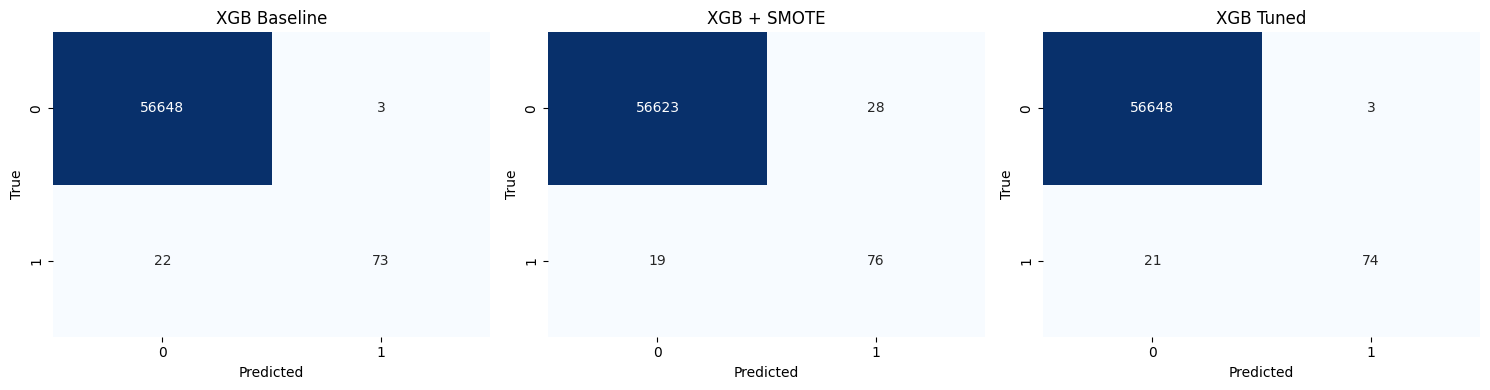

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models_preds = {
    "XGB Baseline": y_pred_baseline,
    "XGB + SMOTE": y_pred_smote,
    "XGB Tuned": y_pred_tuned,
}

for ax, (name, y_pred) in zip(axes, models_preds.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()

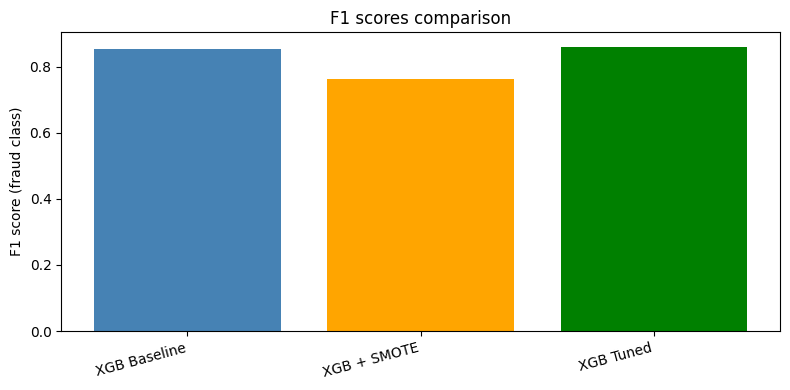

In [14]:
plt.figure(figsize=(8, 4))
plt.bar(results_df["model"], results_df["f1"], color=["steelblue", "orange", "green"])
plt.ylabel("F1 score (fraud class)")
plt.title("F1 scores comparison")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()

## 5. Feature importance

One nice thing about tree-based models like XGBoost is that we can see which features are most important for the predictions. The model calculates importance based on how often a feature is used in the trees and how much it improves the predictions.

Lets see which features matter most for detecting fraud:

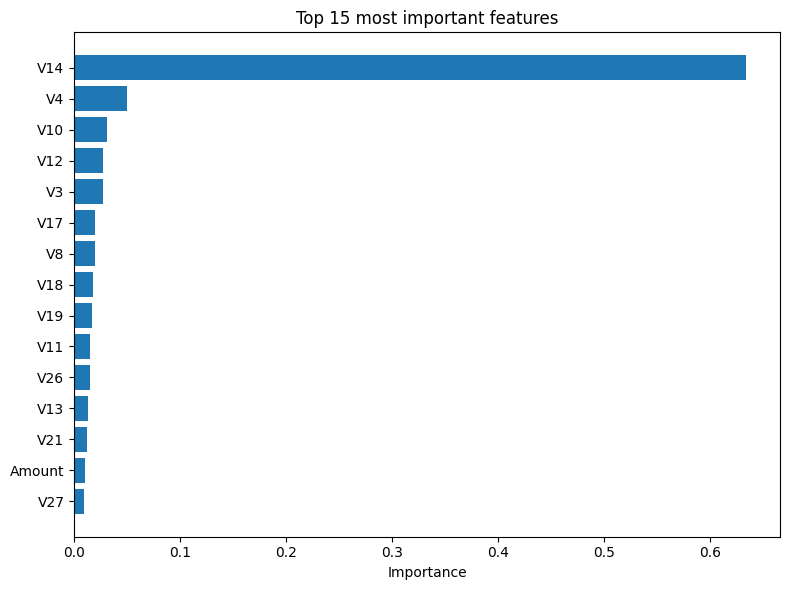

Top 10 features:
feature  importance
    V14    0.634665
     V4    0.049408
    V10    0.030549
    V12    0.027314
     V3    0.027120
    V17    0.019387
     V8    0.019230
    V18    0.017759
    V19    0.016548
    V11    0.015237


In [15]:
xgb_model = best_xgb.named_steps["model"]
importances = xgb_model.feature_importances_

feature_names = numeric_to_scale + other_features

importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8, 6))
plt.barh(importance_df["feature"][:15][::-1], importance_df["importance"][:15][::-1])
plt.xlabel("Importance")
plt.title("Top 15 most important features")
plt.tight_layout()
plt.show()

print("Top 10 features:")
print(importance_df.head(10).to_string(index=False))

V14 dominates the feature importance with 63%, while other features contribute much less. Since these are PCA transformed features used to protect privacy, this confirms that the transformation successfully preserved the key fraud patterns while hiding the real customer data.

## 6. Conclusion

We got really good results with XGBoost on our fraud detection problem. We tried three different approaches:

1. **Baseline with scale_pos_weight**: This works well out of the box. As explained in Chen & Guestrin (2016), this parameter helps the model pay more attention to the minority class.
2. **SMOTE oversampling**: We create synthetic fraud samples to balance the data before training.
3. **Hyperparameter tuning**: We fine-tune the model parameters using RandomizedSearchCV.

The tuned model performs best with an F1 score of 0.86, followed closely by the baseline (0.85). Both beat our Random Forest model from step 3 that got 0.83. The tuned model catches 74 out of 95 frauds (77.9% recall) with only 3 false alarms. This means when we flag a transaction as fraud, we are right 96% of the time.

**Why SMOTE performed worse:**

Interestingly, SMOTE did not improve our results. It has higher recall (80% vs 77%) but much lower precision (73% vs 96%), which gives a lower F1 score (0.76 vs 0.86). This happens because SMOTE creates synthetic fraud samples by interpolating between existing ones, but these artificial samples might not capture the real patterns of fraud. The model becomes more aggressive at predicting fraud, which catches more real frauds but also creates many more false alarms.

For our problem, scale_pos_weight is a better approach than SMOTE because it adjusts the loss function without changing the data distribution. The paper mentions that XGBoost uses regularization to prevent overfitting, which explains why it generalizes well even without synthetic data augmentation.

**Our recommendation:**

We recommend the tuned XGBoost model as our final choice. It gives the best balance between catching frauds and avoiding false positives. The sequential tree building approach described in the paper, where each tree corrects the mistakes of the previous ones, works really well for detecting fraud patterns in our data.
